This Notebook analyses all the results for all the regions in the challenge

In [1]:
%cd '/home/urbanaq/cams_downscaling'

/home/urbanaq/cams_downscaling


In [2]:
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from cams_downscaling.utils import get_db_connection, read_config

In [3]:
config = read_config('/home/urbanaq/cams_downscaling/config')

In [4]:
def get_validation_data(version, date_ini, date_end):
    conn = get_db_connection()
    cursor = conn.cursor()
    
    cursor.execute(f"SELECT station, model_version, MQI, fraction, RMSE, beta, RMS_U, bias, CRMSE FROM validation WHERE model_version = {version} AND time_ini = '{date_ini}' AND time_end = '{date_end}' AND station != '90th'")
    validation = cursor.fetchall()
    cursor.close()
    conn.close()

    validation = pd.DataFrame(validation, columns=["station_id", "version", "MQI", "fraction", "RMSE", "beta", "RMS_U", "bias", "CRMSE"])

    validation.MQI = validation.MQI.astype(float)
    validation.fraction = validation.fraction.astype(float)
    validation.RMSE = validation.RMSE.astype(float)
    validation.beta = validation.beta.astype(float)
    validation.RMS_U = validation.RMS_U.astype(float)
    validation.bias = validation.bias.astype(float)
    validation.CRMSE = validation.CRMSE.astype(float)
    
    return validation

# 1. Iberia

In [5]:
countries = ["Spain", "Portugal"]
region = "iberia"

In [6]:
conn = get_db_connection()
cursor = conn.cursor()

In [7]:
query = "SELECT station_id, cluster, lat, lon FROM stations WHERE cluster IS NOT NULL AND country IN %s"
print(query % (tuple(countries),))
cursor.execute(query, (countries,))
clusters = cursor.fetchall()
cursor.close()
conn.close()

clusters = pd.DataFrame(clusters, columns=["station_id", "cluster", "lat", "lon"])
clusters

SELECT station_id, cluster, lat, lon FROM stations WHERE cluster IS NOT NULL AND country IN ('Spain', 'Portugal')


,station_id,cluster,lat,lon
0,ES0041A,1013,43.2588,-2.9457
1,ES0110A,1014,43.3027,-2.9772
2,ES0118A,101,40.4217,-3.6822
3,ES0120A,101,40.4517,-3.6772
4,ES0124A,101,40.4400,-3.6392
...,...,...,...,...
161,PT03087,200,38.7050,-9.2103
162,PT03095,200,38.6586,-9.0669
163,PT03097,200,38.8022,-9.1822
164,PT03100,200,38.7481,-9.2025


## 1.1 Validate 2022

In [8]:
date_ini = "2022-01-01 00:00:00"
date_end = "2022-12-31 00:00:00"
cams_version_raw = -2000
model_versions = [2001, 2011, 2021, 2031, 2041, 2061, 2071, 2081, 2091, 2101]

date_ini_dt = dt.datetime.strptime(date_ini, "%Y-%m-%d %H:%M:%S")
date_end_dt = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S")

In [9]:
all_df = []

all_df.append(get_validation_data(cams_version_raw, date_ini, date_end))
for model_version in model_versions:
    all_df.append(get_validation_data(model_version, date_ini, date_end))

all_df = pd.concat(all_df)
all_df = pd.merge(all_df, clusters, on="station_id", how="left")
all_df

,station_id,version,MQI,fraction,RMSE,beta,RMS_U,bias,CRMSE,cluster,lat,lon
0,ES0118A,2001,1.299,0.222,47.001,2.0,18.088,-15.154,44.491,101,40.4217,-3.6822
1,ES0822A,2001,1.650,0.434,61.596,2.0,18.665,-54.824,28.079,103,37.2796,-6.9381
2,ES0880A,2001,1.175,0.624,42.032,2.0,17.879,-30.445,28.979,105,43.5512,-5.9197
3,ES0890A,2001,1.208,0.553,43.762,2.0,18.106,-25.924,35.257,104,37.3945,-6.0031
4,ES1044A,2001,1.240,0.602,45.101,2.0,18.188,-30.023,33.655,100,41.6703,-0.8711
...,...,...,...,...,...,...,...,...,...,...,...,...
157,ES2132A,2091,1.157,0.707,41.492,2.0,17.934,-28.201,30.435,106,43.5427,-5.7093
158,PT01023,2091,1.603,0.155,60.047,2.0,18.734,-50.599,32.332,201,41.2067,-8.5528
159,PT01051,2091,1.392,0.326,50.721,2.0,18.215,-39.888,31.330,201,41.3086,-8.7208
160,PT03085,2091,1.316,0.252,47.890,2.0,18.196,-35.022,32.664,200,38.8297,-9.1644


In [10]:
q90_by_version = all_df.groupby("version").MQI.quantile(0.9)
q90_by_cluster_version = pd.pivot_table(all_df, index="cluster", columns="version", values="MQI", aggfunc=lambda x: np.percentile(x, 90))

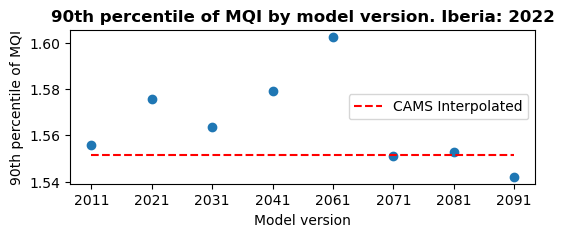

In [11]:
# Plot q90_by_version as points.
versions = q90_by_version.index.values
values = q90_by_version.values

fig, ax = plt.subplots(figsize=(6,2))
ax.scatter(versions[1:], values[1:])
ax.hlines(values[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")

ax.set_xlabel("Model version")
ax.set_ylabel("90th percentile of MQI")

ax.set_xticks(versions[1:])
ax.set_xticklabels(versions[1:])

# Legend outside the plot. lower center
ax.legend(loc="center right")
plt.title(f'90th percentile of MQI by model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

plt.show()


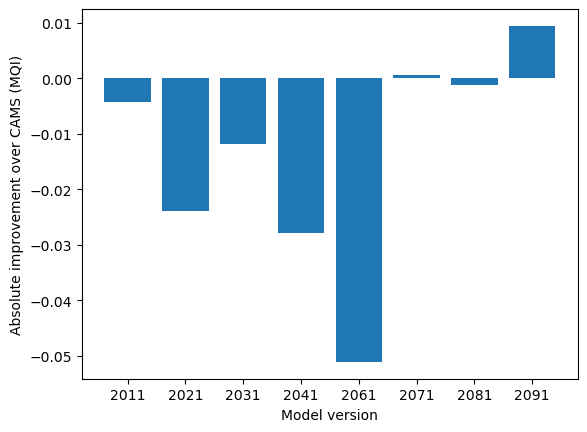

In [12]:
# Improvement over CAMS
versions = q90_by_version.index.values[1:]
values = q90_by_version.values
values = values[0] - values
values = values[1:]

fig, ax = plt.subplots()
ax.bar(versions, values)

ax.set_xlabel("Model version")
ax.set_ylabel("Absolute improvement over CAMS (MQI)")

plt.show()


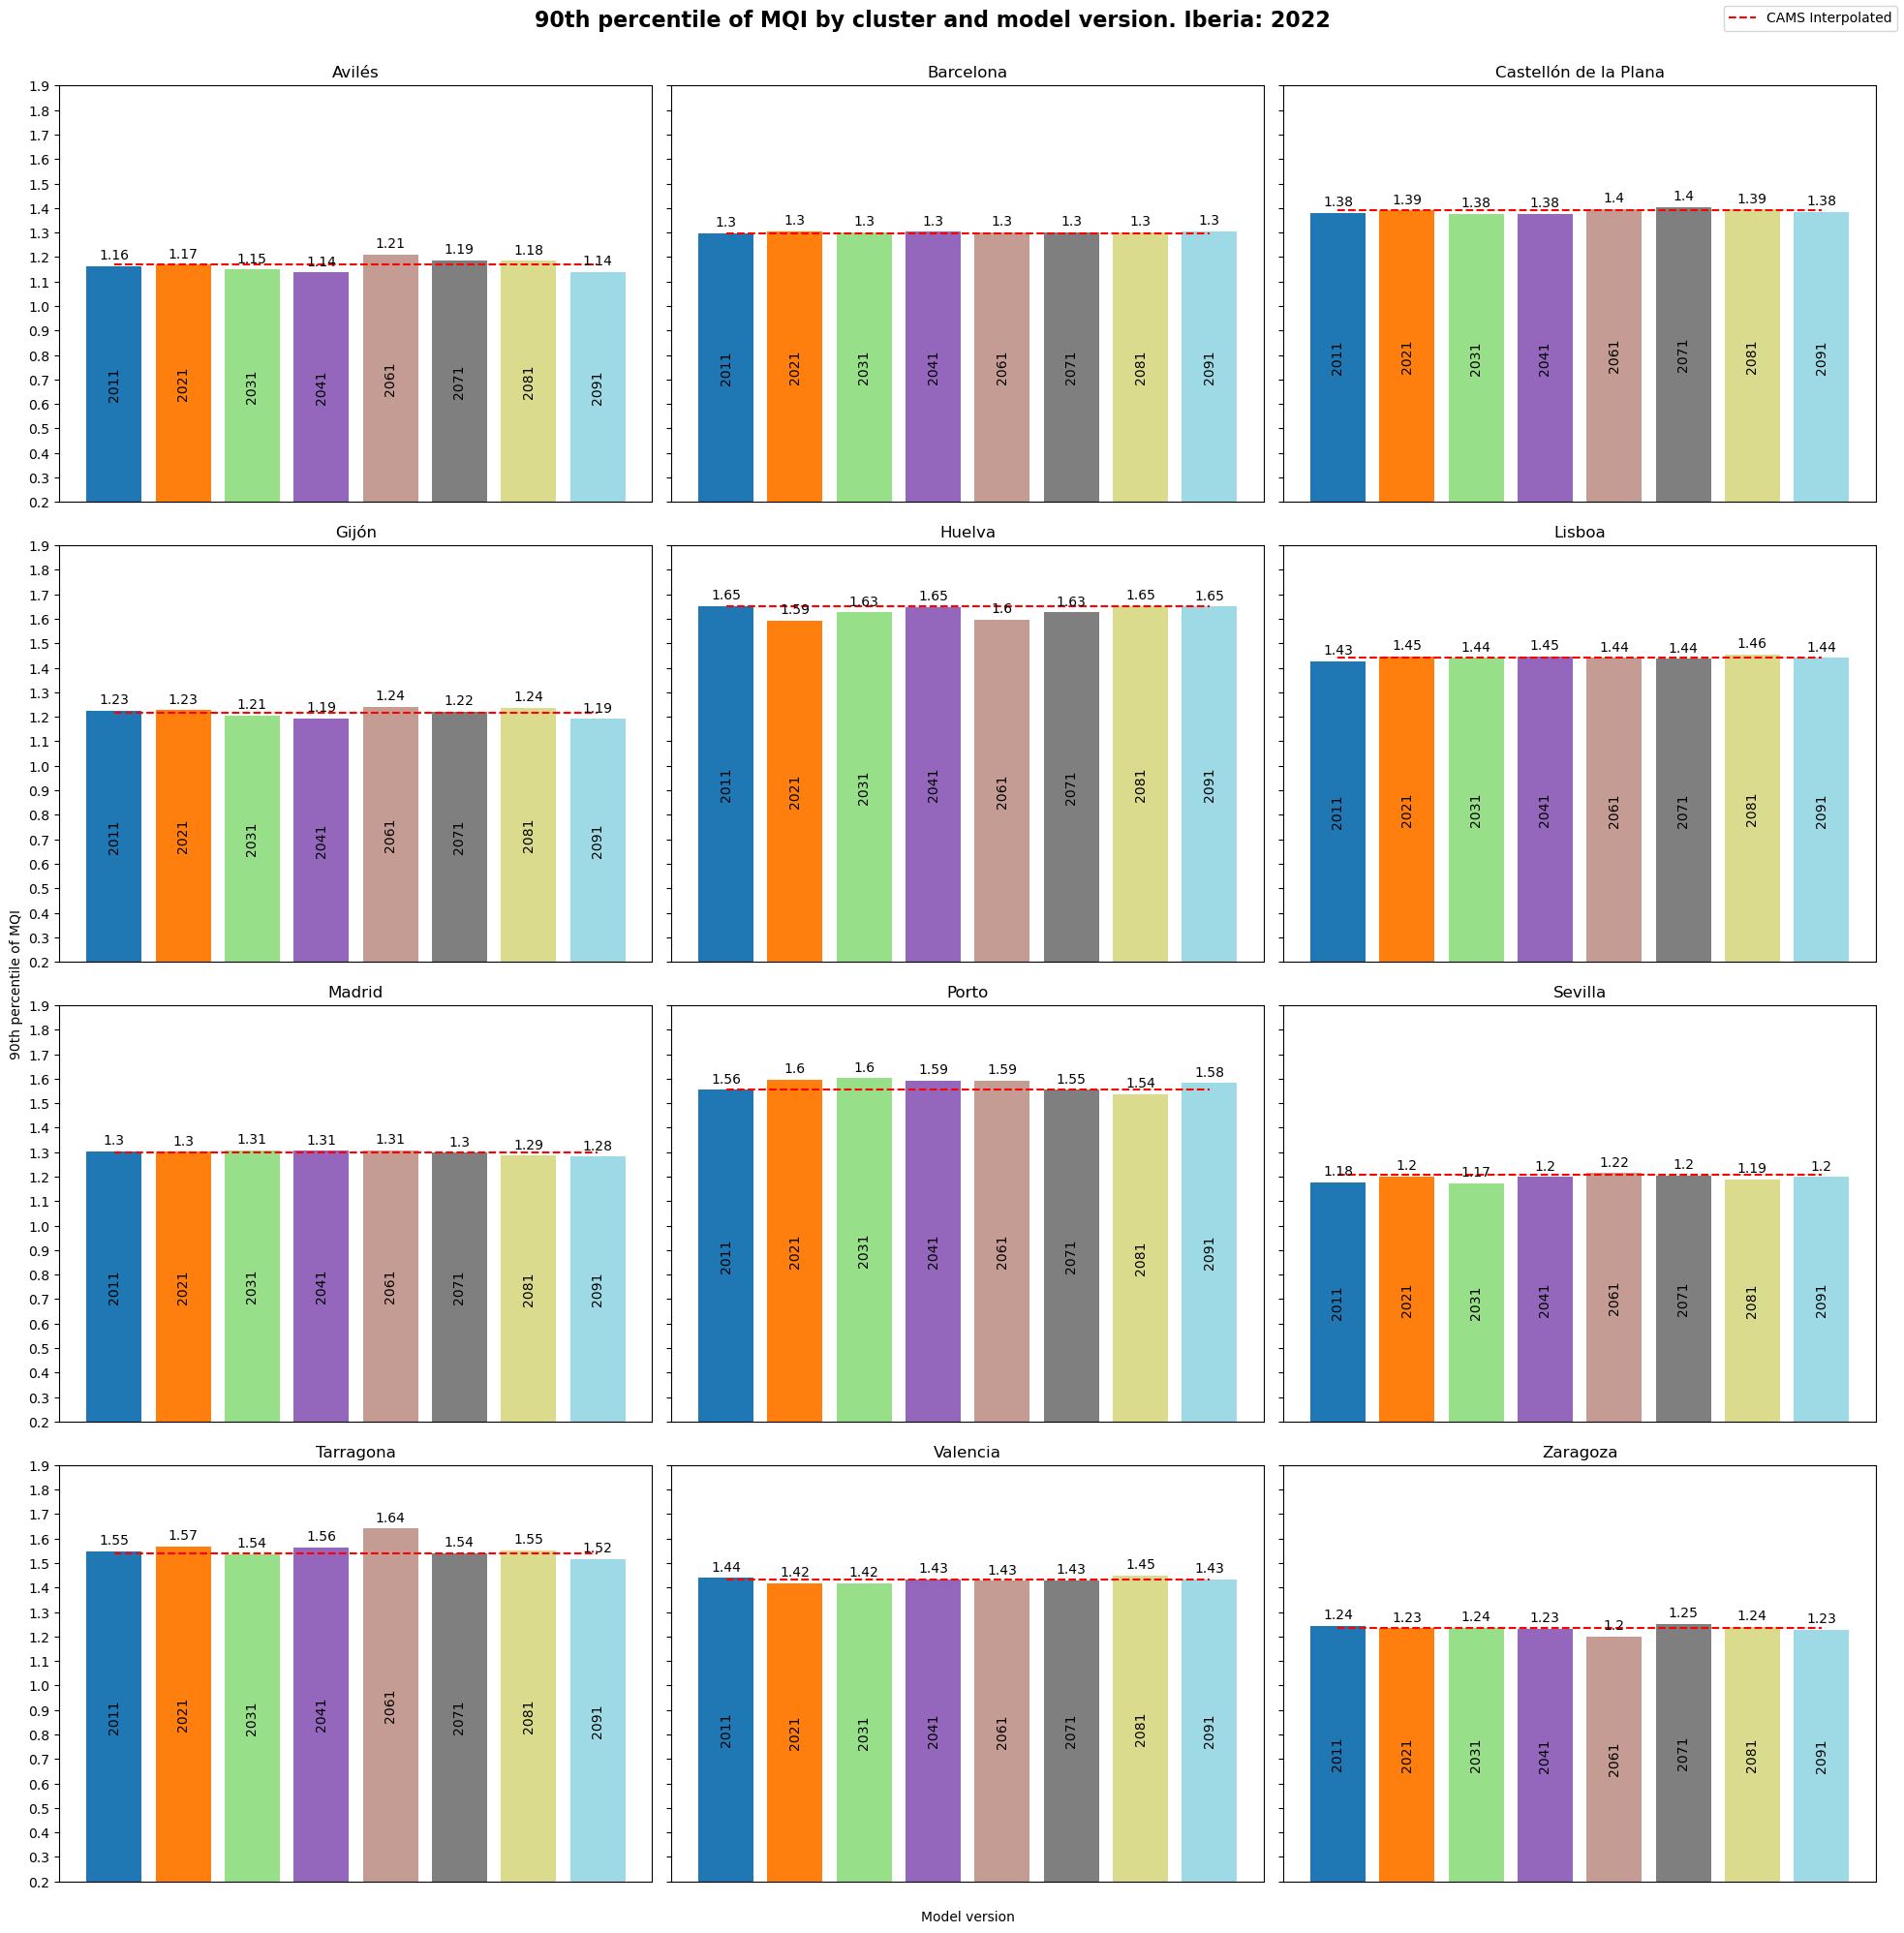

In [18]:
# Modify the index of q90_by_cluster_version to use cluster names.
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed = df_renamed.sort_index()
versions = df_renamed.columns.values.copy()
versions[0] = "CAMS"
colors = plt.get_cmap('tab20', len(versions[1:])).colors

fig, ax = plt.subplots(4, len(df_renamed.index) // 4, figsize=(20, 20), sharex=True, sharey=True)

for i, cluster in enumerate(df_renamed.index):
    rects = ax[i // 3, i % 3].bar(df_renamed.columns[1:], df_renamed.loc[cluster][1:], color=colors)
    labels = np.round(df_renamed.loc[cluster][1:].values, 2)
    ax[i // 3, i % 3].bar_label(rects, labels, padding=3)
    ax[i // 3, i % 3].bar_label(rects, versions[1:], label_type="center", rotation=90)
    ax[i // 3, i % 3].hlines(df_renamed.loc[cluster].iloc[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")
    ax[i // 3, i % 3].set_title(cluster)
    ax[i // 3, i % 3].set_ylim(0.2, 1.1)

    
    ax[i // 3, i % 3].set_xticks([])
    ax[i // 3, i % 3].set_xticklabels([])

    # Set y-ticks with 0.1 step
    ax[i // 3, i % 3].set_yticks(np.arange(0.2, 2, 0.1))

    handles, labels = ax[i // 3, i % 3].get_legend_handles_labels()

plt.subplots_adjust(wspace=0, hspace=0.1)

fig.suptitle(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=16)
ax_main = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_main.set_ylabel("90th percentile of MQI")
ax_main.set_xlabel("Model version")
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()

plt.show()

In [19]:
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed.transpose()
df_renamed


version,CAMS,2011,2021,2031,2041,2061,2071,2081,2091
cluster,,,,,,,,,
Zaragoza,1.2357,1.2427,1.2333,1.2350,1.2317,1.2010,1.2507,1.2384,1.2286
Madrid,1.2990,1.3030,1.3020,1.3080,1.3060,1.3070,1.2980,1.2860,1.2820
Huelva,1.6500,1.6530,1.5930,1.6270,1.6490,1.5960,1.6260,1.6510,1.6500
Sevilla,1.2080,1.1760,1.2010,1.1720,1.1980,1.2150,1.2050,1.1900,1.1990
Avilés,1.1700,1.1621,1.1690,1.1485,1.1371,1.2099,1.1873,1.1849,1.1394
Gijón,1.2179,1.2264,1.2274,1.2051,1.1935,1.2415,1.2223,1.2372,1.1921
Barcelona,1.2980,1.2980,1.3050,1.3020,1.3030,1.3010,1.3020,1.3010,1.3050
Tarragona,1.5410,1.5480,1.5680,1.5370,1.5640,1.6410,1.5410,1.5510,1.5160
Lisboa,1.4421,1.4256,1.4478,1.4405,1.4453,1.4400,1.4368,1.4555,1.4402


/tmp/ipykernel_538397/3244530877.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[i], label=version)


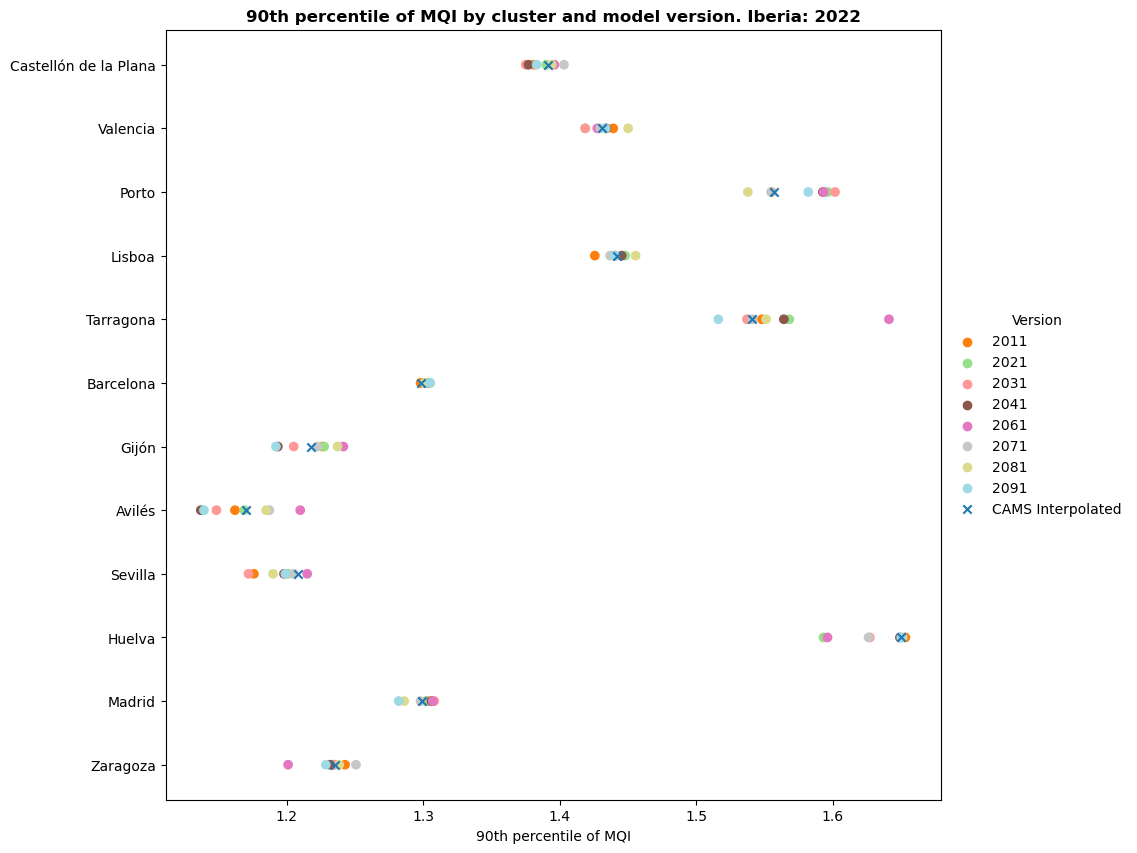

In [20]:
colors = plt.get_cmap('tab20', len(df_renamed.columns)).colors
legend = df_renamed.columns.values
legend[0] = "CAMS"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, row in enumerate(df_renamed.iterrows()):
    cluster, values = row
    ax.scatter(values[1:], [i] * len(values[1:]), c=colors[1:])
    ax.scatter(values.iloc[0], i, color=colors[0], marker="x")

ax.set_yticks(range(len(df_renamed.index)))
ax.set_yticklabels(df_renamed.index)
ax.set_xlabel("90th percentile of MQI")

# Add legend for each version
for i, version in enumerate(list(legend[1:])):
    i = i+1
    plt.scatter([], [], c=colors[i], label=version)
plt.scatter([], [], color=colors[0], marker="x", label="CAMS Interpolated")
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, title='Version', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=12)

plt.show()


In [21]:
q90_map = q90_by_cluster_version.iloc[:, 1:].quantile(0.9, axis=1)
items = []
for i in q90_map.items():
    #lat = clusters[clusters.cluster == i[0]].lat.mean()
    #lon = clusters[clusters.cluster == i[0]].lon.mean()
    lat = clusters[clusters.cluster == i[0]].lat.values[0]
    lon = clusters[clusters.cluster == i[0]].lon.values[0]
    cluster = config["places"]["cluster_names"][i[0]]
    items.append((cluster, lat, lon, i[1]))

q90_map = pd.DataFrame(items, columns=["cluster", "lat", "lon", "MQI"])
q90_map

,cluster,lat,lon,MQI
0,Zaragoza,41.6703,-0.8711,1.24510
1,Madrid,40.4217,-3.6822,1.30730
2,Huelva,37.1903,-6.9045,1.65160
3,Sevilla,37.3843,-5.9596,1.20800
4,Avilés,43.5503,-5.8989,1.19408
5,Gijón,43.5299,-5.6735,1.23849
6,Barcelona,41.4039,2.2045,1.30500
7,Tarragona,41.1159,1.1920,1.58990
8,Lisboa,38.6667,-9.0478,1.45011
9,Porto,41.1997,-8.6447,1.59772


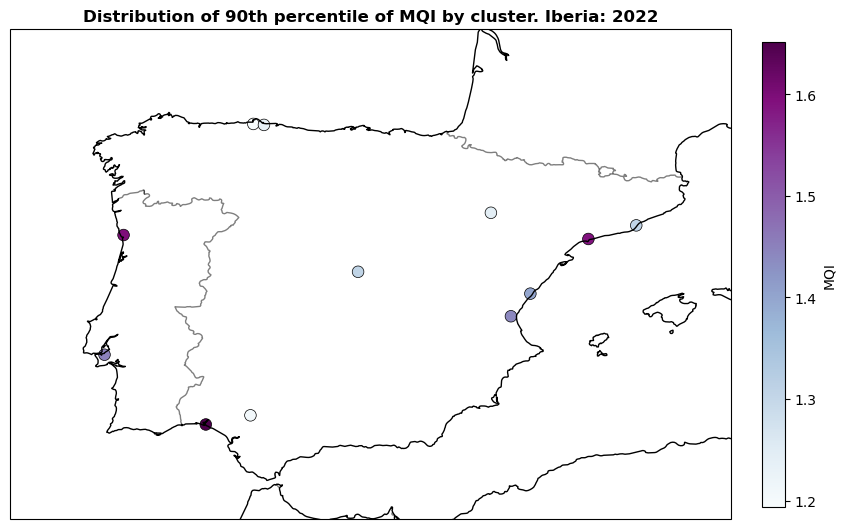

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)

norm = mcolors.Normalize(vmin=q90_map["MQI"].min(), vmax=q90_map["MQI"].max())
cmap = cm.BuPu

sc = ax.scatter(q90_map['lon'], q90_map['lat'], c=q90_map['MQI'], cmap=cmap, norm=norm, s=70, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(q90_map['lon'].min() - 2, q90_map['lon'].max() + 2)
ax.set_ylim(q90_map['lat'].min() - 2, q90_map['lat'].max() + 2)

ax.set_title(f'Distribution of 90th percentile of MQI by cluster. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('MQI')

plt.show()

## 1.2 Validate 2022 and 2023

In [23]:
date_ini = "2022-01-01 00:00:00"
date_end = "2023-12-31 00:00:00"
cams_version_raw = -1000
model_versions = [1000, 1010, 1020, 1030, 1040, 1060, 1070, 1080, 1090, 1100]

date_ini_dt = dt.datetime.strptime(date_ini, "%Y-%m-%d %H:%M:%S")
date_end_dt = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S")

In [ ]:
all_df = []

all_df.append(get_validation_data(cams_version_raw, date_ini, date_end))
for model_version in model_versions:
    all_df.append(get_validation_data(model_version, date_ini, date_end))

all_df = pd.concat(all_df)
all_df = pd.merge(all_df, clusters, on="station_id", how="left")
all_df = all_df[~(all_df.cluster == 1014)]  # Remove Erandio
all_df

In [37]:
q90_by_version = all_df.groupby("version").MQI.quantile(0.9)
q90_by_cluster_version = pd.pivot_table(all_df, index="cluster", columns="version", values="MQI", aggfunc=lambda x: np.percentile(x, 90))

In [ ]:
# Plot q90_by_version as points.
versions = q90_by_version.index.values
values = q90_by_version.values

fig, ax = plt.subplots(figsize=(6,2))
ax.scatter(versions[1:], values[1:])
ax.hlines(values[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")

ax.set_xlabel("Model version")
ax.set_ylabel("90th percentile of MQI")

ax.set_xticks(versions[1:])
ax.set_xticklabels(versions[1:])

# Legend outside the plot. lower center
ax.legend(loc="center right")
plt.title(f'90th percentile of MQI by model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

plt.show()

In [ ]:
# Improvement over CAMS
versions = q90_by_version.index.values[1:]
values = q90_by_version.values
values = values[0] - values
values = values[1:]

fig, ax = plt.subplots()
ax.bar(versions, values)

ax.set_xlabel("Model version")
ax.set_ylabel("Absolute improvement over CAMS (MQI)")

plt.title("Iberia 2022-2023")

plt.show()

In [ ]:
# Modify the index of q90_by_cluster_version to use cluster names.
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed = df_renamed.sort_index()
versions = df_renamed.columns.values.copy()
versions[0] = "CAMS"
colors = plt.get_cmap('tab20', len(versions[1:])).colors

fig, ax = plt.subplots(4, len(df_renamed.index) // 4, figsize=(20, 20), sharex=True, sharey=True)

for i, cluster in enumerate(df_renamed.index):
    rects = ax[i // 4, i % 4].bar(df_renamed.columns[1:], df_renamed.loc[cluster][1:], color=colors)
    labels = np.round(df_renamed.loc[cluster][1:].values, 2)
    ax[i // 4, i % 4].bar_label(rects, labels, padding=3)
    ax[i // 4, i % 4].bar_label(rects, versions[1:], label_type="center", rotation=90)
    ax[i // 4, i % 4].hlines(df_renamed.loc[cluster].iloc[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")
    ax[i // 4, i % 4].set_title(cluster)
    ax[i // 4, i % 4].set_ylim(0.2, 1.1)

    
    ax[i // 4, i % 4].set_xticks([])
    ax[i // 4, i % 4].set_xticklabels([])

    # Set y-ticks with 0.1 step
    ax[i // 4, i % 4].set_yticks(np.arange(0.2, 1.15, 0.1))

    handles, labels = ax[i // 4, i % 4].get_legend_handles_labels()

plt.subplots_adjust(wspace=0, hspace=0.1)

fig.suptitle(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=16)
ax_main = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_main.set_ylabel("90th percentile of MQI")
ax_main.set_xlabel("Model version")
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()

plt.show()

In [ ]:
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed.transpose()
df_renamed

In [ ]:
colors = plt.get_cmap('tab20', len(df_renamed.columns)).colors
legend = df_renamed.columns.values
legend[0] = "CAMS"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, row in enumerate(df_renamed.iterrows()):
    cluster, values = row
    ax.scatter(values[1:], [i] * len(values[1:]), c=colors[1:])
    ax.scatter(values.iloc[0], i, color=colors[0], marker="x")

ax.set_yticks(range(len(df_renamed.index)))
ax.set_yticklabels(df_renamed.index)
ax.set_xlabel("90th percentile of MQI")

# Add legend for each version
for i, version in enumerate(list(legend[1:])):
    i = i+1
    plt.scatter([], [], c=colors[i], label=version)
plt.scatter([], [], color=colors[0], marker="x", label="CAMS Interpolated")
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, title='Version', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=12)

plt.show()

In [ ]:
q90_map = q90_by_cluster_version.iloc[:, 1:].quantile(0.9, axis=1)
items = []
for i in q90_map.items():
    #lat = clusters[clusters.cluster == i[0]].lat.mean()
    #lon = clusters[clusters.cluster == i[0]].lon.mean()
    lat = clusters[clusters.cluster == i[0]].lat.values[0]
    lon = clusters[clusters.cluster == i[0]].lon.values[0]
    cluster = config["places"]["cluster_names"][i[0]]
    items.append((cluster, lat, lon, i[1]))

q90_map = pd.DataFrame(items, columns=["cluster", "lat", "lon", "MQI"])
q90_map

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)

norm = mcolors.Normalize(vmin=q90_map["MQI"].min(), vmax=q90_map["MQI"].max())
cmap = cm.BuPu

sc = ax.scatter(q90_map['lon'], q90_map['lat'], c=q90_map['MQI'], cmap=cmap, norm=norm, s=70, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(q90_map['lon'].min() - 2, q90_map['lon'].max() + 2)
ax.set_ylim(q90_map['lat'].min() - 2, q90_map['lat'].max() + 2)

ax.set_title(f'Distribution of 90th percentile of MQI by cluster. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('MQI')

plt.show()

# 2. Italy

In [45]:
countries = ["Italy"]
region = "italy"

In [ ]:
conn = get_db_connection()
cursor = conn.cursor()
cursor.execute("SELECT station_id, cluster, lat, lon FROM stations WHERE cluster IS NOT NULL AND country IN %s", (countries,))
clusters = cursor.fetchall()
cursor.close()
conn.close()

clusters = pd.DataFrame(clusters, columns=["station_id", "cluster", "lat", "lon"])
clusters

## 2.1 Validate 2022

In [47]:
date_ini = "2022-01-01 00:00:00"
date_end = "2022-12-31 00:00:00"
cams_version_raw = -10001
model_versions = [10011, 10111, 10211, 10311, 10411, 10611, 10711, 10811, 10911, 11011]

date_ini_dt = dt.datetime.strptime(date_ini, "%Y-%m-%d %H:%M:%S")
date_end_dt = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S")

In [ ]:
all_df = []

all_df.append(get_validation_data(cams_version_raw, date_ini, date_end))
for model_version in model_versions:
    all_df.append(get_validation_data(model_version, date_ini, date_end))

all_df = pd.concat(all_df)
all_df = pd.merge(all_df, clusters, on="station_id", how="left")
all_df

In [49]:
q90_by_version = all_df.groupby("version").MQI.quantile(0.9)
q90_by_cluster_version = pd.pivot_table(all_df, index="cluster", columns="version", values="MQI", aggfunc=lambda x: np.percentile(x, 90))

In [ ]:
# Plot q90_by_version as points.
versions = q90_by_version.index.values
values = q90_by_version.values

fig, ax = plt.subplots(figsize=(6,2))
ax.scatter(versions[1:], values[1:])
ax.hlines(values[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")

ax.set_xlabel("Model version")
ax.set_ylabel("90th percentile of MQI")

ax.set_xticks(versions[1:])
ax.set_xticklabels(versions[1:])

# Legend outside the plot. lower center
ax.legend(loc="center right")
plt.title(f'90th percentile of MQI by model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

plt.show()

In [ ]:
# Improvement over CAMS
versions = q90_by_version.index.values[1:]
values = q90_by_version.values
values = values[0] - values
values = values[1:]

fig, ax = plt.subplots()
ax.bar(versions, values)

ax.set_xlabel("Model version")
ax.set_ylabel("Absolute improvement over CAMS (MQI)")

plt.show()

In [ ]:
# Modify the index of q90_by_cluster_version to use cluster names.
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed = df_renamed.sort_index()
versions = df_renamed.columns.values.copy()
versions[0] = "CAMS"
colors = plt.get_cmap('tab20', len(versions[1:])).colors

fig, ax = plt.subplots(4, 2, figsize=(20, 20), sharex=True, sharey=True)

ax = ax.ravel()

for i, cluster in enumerate(df_renamed.index):
    rects = ax[i].bar(df_renamed.columns[1:], df_renamed.loc[cluster][1:], color=colors)
    labels = np.round(df_renamed.loc[cluster][1:].values, 2)
    ax[i].bar_label(rects, labels, padding=3)
    ax[i].bar_label(rects, versions[1:], label_type="center", rotation=90)
    ax[i].hlines(df_renamed.loc[cluster].iloc[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")
    ax[i].set_title(cluster)
    ax[i].set_ylim(0.2, 1.3)

    
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])

    # Set y-ticks with 0.1 step
    ax[i].set_yticks(np.arange(0.2, 1.35, 0.1))

    handles, labels = ax[i].get_legend_handles_labels()

ax[-1].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0.1)

fig.suptitle(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=16)
ax_main = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_main.set_ylabel("90th percentile of MQI")
ax_main.set_xlabel("Model version")
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()

plt.show()

In [ ]:
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed.transpose()
df_renamed

In [ ]:
colors = plt.get_cmap('tab20', len(df_renamed.columns)).colors
legend = df_renamed.columns.values
legend[0] = "CAMS"

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, row in enumerate(df_renamed.iterrows()):
    cluster, values = row
    ax.scatter(values[1:], [i] * len(values[1:]), c=colors[1:])
    ax.scatter(values.iloc[0], i, color=colors[0], marker="x")

ax.set_yticks(range(len(df_renamed.index)))
ax.set_yticklabels(df_renamed.index)
ax.set_xlabel("90th percentile of MQI")

# Add legend for each version
for i, version in enumerate(list(legend[1:])):
    i = i+1
    plt.scatter([], [], c=colors[i], label=version)
plt.scatter([], [], color=colors[0], marker="x", label="CAMS Interpolated")
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, title='Version', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=12)

plt.show()


In [ ]:
q90_map = q90_by_cluster_version.iloc[:, 1:].quantile(0.9, axis=1)
items = []
for i in q90_map.items():
    #lat = clusters[clusters.cluster == i[0]].lat.mean()
    #lon = clusters[clusters.cluster == i[0]].lon.mean()
    lat = clusters[clusters.cluster == i[0]].lat.values[0]
    lon = clusters[clusters.cluster == i[0]].lon.values[0]
    cluster = config["places"]["cluster_names"][i[0]]
    items.append((cluster, lat, lon, i[1]))

q90_map = pd.DataFrame(items, columns=["cluster", "lat", "lon", "MQI"])
q90_map

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)

norm = mcolors.Normalize(vmin=q90_map["MQI"].min(), vmax=q90_map["MQI"].max())
cmap = cm.BuPu

sc = ax.scatter(q90_map['lon'], q90_map['lat'], c=q90_map['MQI'], cmap=cmap, norm=norm, s=70, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(q90_map['lon'].min() - 2, q90_map['lon'].max() + 2)
ax.set_ylim(q90_map['lat'].min() - 2, q90_map['lat'].max() + 2)

ax.set_title(f'Distribution of 90th percentile of MQI by cluster. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('MQI')

plt.show()

## 2.2 Validate 2022 and 2023

In [57]:
date_ini = "2022-01-01 00:00:00"
date_end = "2023-12-31 00:00:00"
cams_version_raw = -10001
model_versions = [10001, 10101, 10201, 10301, 10401, 10601, 10701, 10801, 10901, 11001]

date_ini_dt = dt.datetime.strptime(date_ini, "%Y-%m-%d %H:%M:%S")
date_end_dt = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S")

In [ ]:
all_df = []

all_df.append(get_validation_data(cams_version_raw, date_ini, date_end))
for model_version in model_versions:
    all_df.append(get_validation_data(model_version, date_ini, date_end))

all_df = pd.concat(all_df)
all_df = pd.merge(all_df, clusters, on="station_id", how="left")
all_df

In [59]:
q90_by_version = all_df.groupby("version").MQI.quantile(0.9)
q90_by_cluster_version = pd.pivot_table(all_df, index="cluster", columns="version", values="MQI", aggfunc=lambda x: np.percentile(x, 90))

In [ ]:
# Plot q90_by_version as points.
versions = q90_by_version.index.values
values = q90_by_version.values

fig, ax = plt.subplots(figsize=(6,2))
ax.scatter(versions[1:], values[1:])
ax.hlines(values[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")

ax.set_xlabel("Model version")
ax.set_ylabel("90th percentile of MQI")

ax.set_xticks(versions[1:])
ax.set_xticklabels(versions[1:])

# Legend outside the plot. lower center
ax.legend(loc="center right")
plt.title(f'90th percentile of MQI by model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

plt.show()

In [ ]:
# Improvement over CAMS
versions = q90_by_version.index.values[1:]
values = q90_by_version.values
values = values[0] - values
values = values[1:]

fig, ax = plt.subplots()
ax.bar(versions, values)

ax.set_xlabel("Model version")
ax.set_ylabel("Absolute improvement over CAMS (MQI)")

plt.show()

In [ ]:
# Modify the index of q90_by_cluster_version to use cluster names.
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed = df_renamed.sort_index()
versions = df_renamed.columns.values.copy()
versions[0] = "CAMS"
colors = plt.get_cmap('tab20', len(versions[1:])).colors

fig, ax = plt.subplots(4, 2, figsize=(20, 20), sharex=True, sharey=True)

ax = ax.ravel()

for i, cluster in enumerate(df_renamed.index):
    rects = ax[i].bar(df_renamed.columns[1:], df_renamed.loc[cluster][1:], color=colors)
    labels = np.round(df_renamed.loc[cluster][1:].values, 2)
    ax[i].bar_label(rects, labels, padding=3)
    ax[i].bar_label(rects, versions[1:], label_type="center", rotation=90)
    ax[i].hlines(df_renamed.loc[cluster].iloc[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")
    ax[i].set_title(cluster)
    ax[i].set_ylim(0.2, 1.3)

    
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])

    # Set y-ticks with 0.1 step
    ax[i].set_yticks(np.arange(0.2, 1.35, 0.1))

    handles, labels = ax[i].get_legend_handles_labels()

ax[-1].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0.1)

fig.suptitle(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=16)
ax_main = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_main.set_ylabel("90th percentile of MQI")
ax_main.set_xlabel("Model version")
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()

plt.show()

In [ ]:
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed.transpose()
df_renamed

In [ ]:
colors = plt.get_cmap('tab20', len(df_renamed.columns)).colors
legend = df_renamed.columns.values
legend[0] = "CAMS"

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, row in enumerate(df_renamed.iterrows()):
    cluster, values = row
    ax.scatter(values[1:], [i] * len(values[1:]), c=colors[1:])
    ax.scatter(values.iloc[0], i, color=colors[0], marker="x")

ax.set_yticks(range(len(df_renamed.index)))
ax.set_yticklabels(df_renamed.index)
ax.set_xlabel("90th percentile of MQI")

# Add legend for each version
for i, version in enumerate(list(legend[1:])):
    i = i+1
    plt.scatter([], [], c=colors[i], label=version)
plt.scatter([], [], color=colors[0], marker="x", label="CAMS Interpolated")
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, title='Version', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=12)

plt.show()


In [ ]:
q90_map = q90_by_cluster_version.iloc[:, 1:].quantile(0.9, axis=1)
items = []
for i in q90_map.items():
    #lat = clusters[clusters.cluster == i[0]].lat.mean()
    #lon = clusters[clusters.cluster == i[0]].lon.mean()
    lat = clusters[clusters.cluster == i[0]].lat.values[0]
    lon = clusters[clusters.cluster == i[0]].lon.values[0]
    cluster = config["places"]["cluster_names"][i[0]]
    items.append((cluster, lat, lon, i[1]))

q90_map = pd.DataFrame(items, columns=["cluster", "lat", "lon", "MQI"])
q90_map

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)

norm = mcolors.Normalize(vmin=q90_map["MQI"].min(), vmax=q90_map["MQI"].max())
cmap = cm.BuPu

sc = ax.scatter(q90_map['lon'], q90_map['lat'], c=q90_map['MQI'], cmap=cmap, norm=norm, s=70, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(q90_map['lon'].min() - 2, q90_map['lon'].max() + 2)
ax.set_ylim(q90_map['lat'].min() - 2, q90_map['lat'].max() + 2)

ax.set_title(f'Distribution of 90th percentile of MQI by cluster. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('MQI')

plt.show()

# 3. Poland

In [67]:
countries = ["Poland"]
region = "poland"

In [ ]:
conn = get_db_connection()
cursor = conn.cursor()
cursor.execute("SELECT station_id, cluster, lat, lon FROM stations WHERE cluster IS NOT NULL AND country IN %s", (countries,))
clusters = cursor.fetchall()
cursor.close()
conn.close()

clusters = pd.DataFrame(clusters, columns=["station_id", "cluster", "lat", "lon"])
clusters

## 3.1 Validate 2022

*Note: Poland only has 2022 available*

In [69]:
date_ini = "2022-01-01 00:00:00"
date_end = "2022-12-31 00:00:00"
cams_version_raw = -10002
model_versions = [10012, 10112, 10212, 10312, 10412, 10612, 10712, 10812, 10912, 11012]

date_ini_dt = dt.datetime.strptime(date_ini, "%Y-%m-%d %H:%M:%S")
date_end_dt = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S")

In [ ]:
all_df = []

all_df.append(get_validation_data(cams_version_raw, date_ini, date_end))
for model_version in model_versions:
    all_df.append(get_validation_data(model_version, date_ini, date_end))

all_df = pd.concat(all_df)
all_df = pd.merge(all_df, clusters, on="station_id", how="left")
all_df

In [71]:
q90_by_version = all_df.groupby("version").MQI.quantile(0.9)
q90_by_cluster_version = pd.pivot_table(all_df, index="cluster", columns="version", values="MQI", aggfunc=lambda x: np.percentile(x, 90))

In [ ]:
q90_by_version

In [ ]:
q90_by_cluster_version

In [ ]:
# Plot q90_by_version as points.
versions = q90_by_version.index.values
values = q90_by_version.values

fig, ax = plt.subplots(figsize=(6,2))
ax.scatter(versions[1:], values[1:])
ax.hlines(values[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")

ax.set_xlabel("Model version")
ax.set_ylabel("90th percentile of MQI")

ax.set_xticks(versions[1:])
ax.set_xticklabels(versions[1:])

# Legend outside the plot. lower center
ax.legend(loc="center right")
plt.title(f'90th percentile of MQI by model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

plt.show()

In [ ]:
# Improvement over CAMS
versions = q90_by_version.index.values[1:]
values = q90_by_version.values
values = values[0] - values
values = values[1:]

fig, ax = plt.subplots()
ax.bar(versions, values)

ax.set_xlabel("Model version")
ax.set_ylabel("Absolute improvement over CAMS (MQI)")

plt.show()

In [ ]:
# Modify the index of q90_by_cluster_version to use cluster names.
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed = df_renamed.sort_index()
versions = df_renamed.columns.values.copy()
versions[0] = "CAMS"
colors = plt.get_cmap('tab20', len(versions[1:])).colors

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

ax = ax.ravel()

for i, cluster in enumerate(df_renamed.index):
    rects = ax[i].bar(df_renamed.columns[1:], df_renamed.loc[cluster][1:], color=colors)
    labels = np.round(df_renamed.loc[cluster][1:].values, 2)
    ax[i].bar_label(rects, labels, padding=3)
    ax[i].bar_label(rects, versions[1:], label_type="center", rotation=90)
    ax[i].hlines(df_renamed.loc[cluster].iloc[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")
    ax[i].set_title(cluster)
    ax[i].set_ylim(0.2, 1)
    
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])

    # Set y-ticks with 0.1 step
    ax[i].set_yticks(np.arange(0.2, 1.05, 0.1))

    handles, labels = ax[i].get_legend_handles_labels()

plt.subplots_adjust(wspace=0, hspace=0.1)

fig.suptitle(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=16)
ax_main = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_main.set_ylabel("90th percentile of MQI")
ax_main.set_xlabel("Model version")
fig.legend(handles, labels, loc='lower right')

plt.tight_layout()

plt.show()

In [ ]:
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed.transpose()
df_renamed

In [ ]:
colors = plt.get_cmap('tab20', len(df_renamed.columns)).colors
legend = df_renamed.columns.values
legend[0] = "CAMS"

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i, row in enumerate(df_renamed.iterrows()):
    cluster, values = row
    ax.scatter(values[1:], [i] * len(values[1:]), c=colors[1:])
    ax.scatter(values.iloc[0], i, color=colors[0], marker="x")

ax.set_yticks(range(len(df_renamed.index)))
ax.set_yticklabels(df_renamed.index)
ax.set_xlabel("90th percentile of MQI")

# Add legend for each version
for i, version in enumerate(list(legend[1:])):
    i = i+1
    plt.scatter([], [], c=colors[i], label=version)
plt.scatter([], [], color=colors[0], marker="x", label="CAMS Interpolated")
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, title='Version', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=12)

plt.show()

In [ ]:
q90_map = q90_by_cluster_version.iloc[:, 1:].quantile(0.9, axis=1)
items = []
for i in q90_map.items():
    #lat = clusters[clusters.cluster == i[0]].lat.mean()
    #lon = clusters[clusters.cluster == i[0]].lon.mean()
    lat = clusters[clusters.cluster == i[0]].lat.values[0]
    lon = clusters[clusters.cluster == i[0]].lon.values[0]
    cluster = config["places"]["cluster_names"][i[0]]
    items.append((cluster, lat, lon, i[1]))

q90_map = pd.DataFrame(items, columns=["cluster", "lat", "lon", "MQI"])
q90_map

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)


norm = mcolors.Normalize(vmin=q90_map["MQI"].min(), vmax=q90_map["MQI"].max())
cmap = cm.BuPu

sc = ax.scatter(q90_map['lon'], q90_map['lat'], c=q90_map['MQI'], cmap=cmap, norm=norm, s=70, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(q90_map['lon'].min() - 2, q90_map['lon'].max() + 2)
ax.set_ylim(q90_map['lat'].min() - 2, q90_map['lat'].max() + 2)

ax.set_title(f'Distribution of 90th percentile of MQI by cluster. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('MQI')

plt.show()